importing important libraries

In [ ]:
import re
import chardet  
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
#import lightgbm as lgb
import xgboost as xgb
import gc
%matplotlib inline

DATA EXPLORATION

Importing Train and Test DataSets

In [ ]:
train = pd.read_csv('/saurabh/My Drive/Datasets/games/Train.csv')
test = pd.read_csv('/saurabh/My Drive/Datasets/games/Test.csv')

Checking the data

In [ ]:
print(train.head(5))
print(train.shape)
print(test.head(5))
print(test.shape)

     ID CONSOLE  YEAR  ... CRITICS_POINTS USER_POINTS SalesInMillions
0  2860      ds  2008  ...       2.833333    0.303704        1.779257
1   731     wii  2012  ...      13.200000    1.640000        0.215050
2   495      pc  2019  ...       4.562500    0.006410        0.534402
3  2641     ps2  2002  ...       4.181818    0.326923        1.383964
4   811     ps3  2013  ...       2.259259    0.032579        0.082671

[5 rows x 9 columns]
(3505, 9)
     ID CONSOLE  YEAR  ... RATING CRITICS_POINTS USER_POINTS
0  4310     ps2  2008  ...      T       3.928571    0.482353
1  4011     psp  2007  ...   E10+       5.538462    0.071795
2  2185     ps2  2004  ...      T       3.034483    0.062044
3  1644       x  2006  ...      E       2.913043    0.880000
4   188     3ds  2011  ...   E10+       1.162162    0.183333

[5 rows x 8 columns]
(1503, 8)


Checking for null values

In [ ]:
print("Train" )
print(train.isnull().sum())
print("Test")
print(test.isnull().sum())

Train
ID                 0
CONSOLE            0
YEAR               0
CATEGORY           0
PUBLISHER          0
RATING             0
CRITICS_POINTS     0
USER_POINTS        0
SalesInMillions    0
dtype: int64
Test
ID                0
CONSOLE           0
YEAR              0
CATEGORY          0
PUBLISHER         0
RATING            0
CRITICS_POINTS    0
USER_POINTS       0
dtype: int64


In [ ]:

# check for duplicate records... didn't remove the duplicate records as it was bringing score down
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3505 entries, 0 to 3504
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               3505 non-null   int64  
 1   CONSOLE          3505 non-null   object 
 2   YEAR             3505 non-null   int64  
 3   CATEGORY         3505 non-null   object 
 4   PUBLISHER        3505 non-null   object 
 5   RATING           3505 non-null   object 
 6   CRITICS_POINTS   3505 non-null   float64
 7   USER_POINTS      3505 non-null   float64
 8   SalesInMillions  3505 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 246.6+ KB


In [ ]:
for i in train.columns:
    print("Unique values in", i, train[i].nunique())

Unique values in ID 2653
Unique values in CONSOLE 17
Unique values in YEAR 23
Unique values in CATEGORY 12
Unique values in PUBLISHER 204
Unique values in RATING 6
Unique values in CRITICS_POINTS 1683
Unique values in USER_POINTS 2153
Unique values in SalesInMillions 3505


In [ ]:

for i in test.columns:
    print("Unique values in", i, test[i].nunique())

Unique values in ID 1334
Unique values in CONSOLE 17
Unique values in YEAR 25
Unique values in CATEGORY 12
Unique values in PUBLISHER 136
Unique values in RATING 5
Unique values in CRITICS_POINTS 995
Unique values in USER_POINTS 1110


In [ ]:
train.describe()

,ID,YEAR,CRITICS_POINTS,USER_POINTS,SalesInMillions
count,3505.000000,3505.000000,3505.000000,3505.000000,3505.000000
mean,2281.645364,2008.990870,3.791487,0.405933,2.147610
std,1286.985733,4.304734,3.141988,0.455560,2.075260
min,1.000000,1997.000000,0.568966,0.000341,0.001524
25%,1220.000000,2006.000000,1.738095,0.066038,0.965600
50%,2262.000000,2009.000000,2.766667,0.233333,1.865988
75%,3404.000000,2012.000000,4.625000,0.600000,2.791978
max,4523.000000,2019.000000,23.250000,2.325000,34.722026



Checking Distribution Of CRITICS_POINTS



 mu = 3.79 and sigma = 3.14



Text(0.5, 0.98, 'Before transformation')

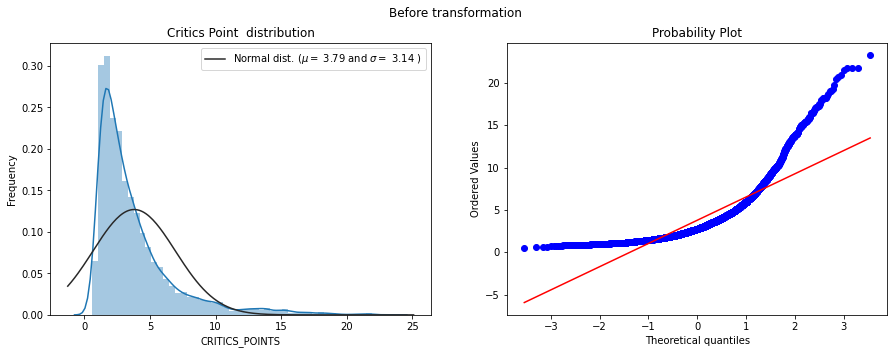

In [ ]:

from scipy import stats
from scipy.stats import norm, skew #for some statistics
# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['CRITICS_POINTS'] , fit=norm);
(mu, sigma) = norm.fit(train['CRITICS_POINTS'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Critics Point  distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['CRITICS_POINTS'], plot=plt)
plt.suptitle('Before transformation')

Checking Distribution Of USER_POINTS


 mu = 0.41 and sigma = 0.46



Text(0.5, 0.98, 'Before transformation')

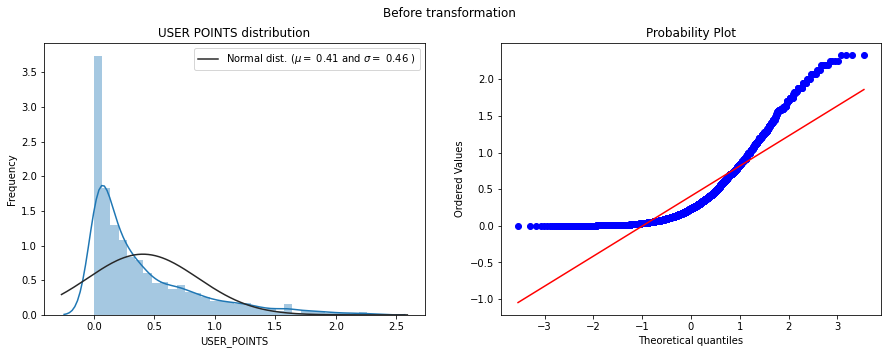

In [ ]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['USER_POINTS'] , fit=norm);
(mu, sigma) = norm.fit(train['USER_POINTS'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('USER POINTS distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['USER_POINTS'], plot=plt)
plt.suptitle('Before transformation')


 mu = 2.15 and sigma = 2.07



Text(0.5, 0.98, 'Before transformation')

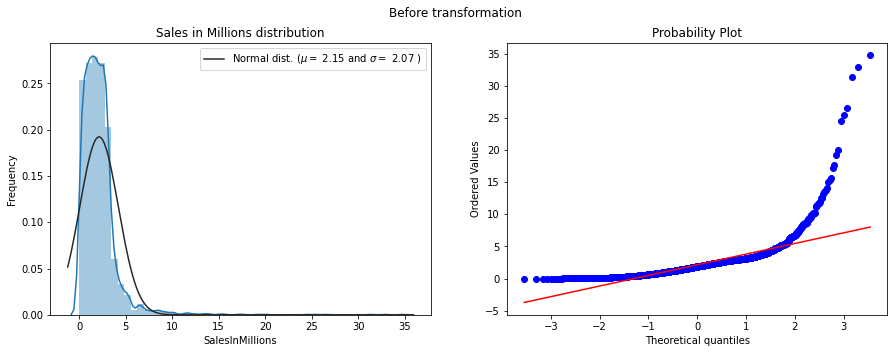

In [ ]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalesInMillions'] , fit=norm);
(mu, sigma) = norm.fit(train['SalesInMillions'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sales in Millions distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalesInMillions'], plot=plt)
plt.suptitle('Before transformation')

DATA PREPROCESSING

In [ ]:
# merge train and test
df = train.append(test,ignore_index=True)

In [ ]:
df.shape

(5008, 9)

In [ ]:
df = pd.get_dummies(df, columns=['RATING'], drop_first=True)

In [ ]:

df.head(5)

,ID,CONSOLE,YEAR,CATEGORY,PUBLISHER,CRITICS_POINTS,USER_POINTS,SalesInMillions,RATING_E,RATING_E10+,RATING_K-A,RATING_M,RATING_RP,RATING_T
0,2860,ds,2008,role-playing,Nintendo,2.833333,0.303704,1.779257,1,0,0,0,0,0
1,731,wii,2012,simulation,Konami Digital Entertainment,13.200000,1.640000,0.215050,0,1,0,0,0,0
2,495,pc,2019,shooter,Activision,4.562500,0.006410,0.534402,0,0,0,1,0,0
3,2641,ps2,2002,sports,Electronic Arts,4.181818,0.326923,1.383964,1,0,0,0,0,0
4,811,ps3,2013,action,Activision,2.259259,0.032579,0.082671,0,0,0,1,0,0


In [ ]:
df = pd.get_dummies(df, columns=['CATEGORY'], drop_first=True)

In [ ]:
df.head(5)

,ID,CONSOLE,YEAR,PUBLISHER,CRITICS_POINTS,USER_POINTS,SalesInMillions,RATING_E,RATING_E10+,RATING_K-A,RATING_M,RATING_RP,RATING_T,CATEGORY_adventure,CATEGORY_fighting,CATEGORY_misc,CATEGORY_platform,CATEGORY_puzzle,CATEGORY_racing,CATEGORY_role-playing,CATEGORY_shooter,CATEGORY_simulation,CATEGORY_sports,CATEGORY_strategy
0,2860,ds,2008,Nintendo,2.833333,0.303704,1.779257,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,731,wii,2012,Konami Digital Entertainment,13.200000,1.640000,0.215050,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,495,pc,2019,Activision,4.562500,0.006410,0.534402,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2641,ps2,2002,Electronic Arts,4.181818,0.326923,1.383964,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,811,ps3,2013,Activision,2.259259,0.032579,0.082671,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.get_dummies(df, columns=['CONSOLE'], drop_first=True)

In [ ]:
df = pd.get_dummies(df, columns=['PUBLISHER'], drop_first=True)

In [ ]:
#df_title.shape

In [ ]:
#df = pd.concat([df, df_title], axis=1) 

In [ ]:
#df.drop(['PUBLISHER'], axis=1, inplace=True)

In [ ]:
df['CRITICS_POINTS'] = np.log1p(df['CRITICS_POINTS'])
df['USER_POINTS'] = np.log1p(df['USER_POINTS'])
#df['SalesInMillions'] = np.log1p(df['SalesInMillions'])


In [ ]:
df.shape

(5008, 270)

In [ ]:
train_df = df[df['SalesInMillions'].isnull()!=True]
test_df = df[df['SalesInMillions'].isnull()==True]
test_df.drop('SalesInMillions', axis=1, inplace=True)

TRAIN TEST SPLIT

In [ ]:
X = train_df.drop(labels=['SalesInMillions'], axis=1)
y = train_df['SalesInMillions'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((2628, 269), (2628,), (877, 269), (877,))

BUILD THE MODEL

In [ ]:
from math import sqrt 
from sklearn.metrics import mean_squared_error

In [ ]:
Xtest =  test_df

In [ ]:
from sklearn.model_selection import KFold, RepeatedKFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []
fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    param = {
         'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.03, 
         'num_iterations': 1000,
         'num_leaves': 35,
         'max_depth': 6,
         'min_data_in_leaf': 15,
         'bagging_fraction': 1,
         'bagging_freq': 1,
         'colsample_bytree':1,
         'reg_alpha' : 0.5,
         'min_child_samples' : 5,
         'min_split_gain':0.2
         }


    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             verbose=0,
             early_stopping_rounds=100
             )

    y_pred_lgbm = lgbm.predict(X_test)
    print('RMSE:', sqrt(mean_squared_error(y_test, y_pred_lgbm)))

    errlgb.append(sqrt(mean_squared_error(y_test, y_pred_lgbm)))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSE: 1.3140447050750848
RMSE: 1.8170636478841835
RMSE: 1.354613644653867
RMSE: 1.713917257306853
RMSE: 1.0938683281126713
RMSE: 2.1528127938896877
RMSE: 1.5598677518147912
RMSE: 1.4180233633470538
RMSE: 1.291393354479917
RMSE: 1.810491380583261
RMSE: 1.458694940382956
RMSE: 2.3167917309814214
RMSE: 1.617547400257916
RMSE: 1.7943015708891168
RMSE: 1.4316895422348492


In [ ]:
np.mean(errlgb,0)

1.609674760792909

In [ ]:
from sklearn.model_selection import KFold, RepeatedKFold
from xgboost import XGBRegressor

errxgb = []
y_pred_toxgb = []
fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = XGBRegressor(n_estimators=3000,learning_rate=0.05,random_state=1994,max_depth=7,reg_alpha=0.00006,colsample_bytree=0.8,max_delta_step=0.8,colsample_bylevel = 0.8 , max_bin = 100,colsample_bynode= 0.5)
    xgb_model.fit(X_train, y_train,
             eval_set=[(X_test, y_test)],
             verbose=0,
             early_stopping_rounds=100
             )

    y_pred_xgb = xgb_model.predict(X_test)
    print('RMSE:', sqrt(mean_squared_error(y_test, y_pred_xgb)))

    errxgb.append(sqrt(mean_squared_error(y_test, y_pred_xgb)))
    p = xgb_model.predict(Xtest)
    y_pred_toxgb.append(p)

[12:23:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.3416877472707687
[12:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.8416378479980287
[12:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.326683221841166
[12:23:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.7146322451078946
[12:23:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.1096887450373745
[12:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.8505453503488252
[12:23:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now dep

In [ ]:
np.mean(errxgb,0)

1.5789661246908715

In [ ]:
xgb_final = np.mean(y_pred_toxgb,0)

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)

In [ ]:
y_pred_final2 = xgb_final*0.30 + lgbm_final*0.70

In [ ]:
e_dataframe = pd.DataFrame(y_pred_final2) 

In [ ]:
e_dataframe.shape

(1503, 1)

In [ ]:
e_dataframe.to_excel('submission_games_finalsg4.xlsx', index=False)

In [ ]:
from google.colab import files

In [ ]:
files.download('submission_games_finalsg4.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>